# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

### Download the data
If you do not have the required **data/** directory in your workspace, follow the instructions below. Use either one of the methods below. 

**Method 1** <br/>
You must [download this dataset](https://video.udacity-data.com/topher/2024/August/66b9ba05_arvato_data.tar/arvato_data.tar.gz) from the Downloads section in the classroom, and upload it into the workspace. After you upload the tar file to the present working  directory, **/workspace/home/**,  in the Jupyter server, you can open a terminal and the run the following command to extract the dataset from the compressed file. 
```bash
!tar -xzvf arvato_data.tar.gz
```
This command will extract all the contents of arvato_data.tar.gz into the current directory. 

**Method 2** <br/>
Execute the Python code below to download the dataset. 


In [1]:
# import requests
# import tarfile
# import os


# def download_and_extract(url, extract_to='.'):
#     """
#     Downloads a tar.gz file from a URL and extracts it to a directory.
#     Args:
#     - url (str): URL of the tar.gz file to download.
#     - extract_to (str): Directory path to extract the contents of the tar.gz file.
#     """
#     # Get the filename from the URL
#     filename = url.split('/')[-1]

#     # Download the file
#     print("Downloading the file...")
#     response = requests.get(url, stream=True)
#     if response.status_code == 200:
#         with open(filename, 'wb') as file:
#             file.write(response.raw.read())
#         print("Download completed.")
#     else:
#         print("Failed to download the file.")
#         return

#     # Extract the tar.gz file
#     print("Extracting the file...")
#     try:
#         with tarfile.open(filename, 'r:gz') as tar:
#             tar.extractall(path=extract_to)
#         print("Extraction completed.")
#     except Exception as e:
#         print(f"Failed to extract the file: {e}")
#     finally:
#         # Optionally remove the tar.gz file after extraction
#         os.remove(filename)
#         print("Downloaded tar.gz file removed.")

# # URL of the tar.gz file
# url = 'https://video.udacity-data.com/topher/2024/August/66b9ba05_arvato_data.tar/arvato_data.tar.gz'

# # Call the function with the URL
# download_and_extract(url)



### Important note
>Delete the data/folder and the downloaded tar file, before you submit your code. The current workspace cannot save the files beyond 1GB of space in total. 

### Import Packages

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight


In [4]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift



## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Load data

In [5]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

/var/folders/h2/0dmxrjm55dv2p0qsyjp2qw1m0000gn/T/ipykernel_22293/4183925281.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
/var/folders/h2/0dmxrjm55dv2p0qsyjp2qw1m0000gn/T/ipykernel_22293/4183925281.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')


In [6]:
print('AZDIAS Data shape ', azdias.shape)

AZDIAS Data shape  (891221, 366)


In [7]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [8]:
print('CUSTOMERS Data shape ', customers.shape)

CUSTOMERS Data shape  (191652, 369)


In [9]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


### Pre-process the Data

#### Compare features between datasets 

In [10]:
attributes_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)

In [11]:
attributes_values.head(2)

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible


In [12]:
attributes_values = attributes_values[attributes_values.columns[1:]]
attributes_values = attributes_values[attributes_values['Attribute'].notnull()]

In [13]:
print('attributes_values data shape ', attributes_values.shape)

attributes_values data shape  (314, 4)


In [14]:
attributes_values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
36,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)


In [15]:
azdias_features_exclusive = list(set(azdias) - set(attributes_values['Attribute'].tolist()))
print('Number of features exclusively in azdias: ', len(azdias_features_exclusive), '\n')

Number of features exclusively in azdias:  94 



In [16]:
customer_features_exclusive = set(customers) - set(azdias)
print('Number of features exclusively in customers: ', len(customer_features_exclusive), '\n')

Number of features exclusively in customers:  3 



#### Deal with unknown values

In the attributes-values dataframe, unknown entries are indicated by one or more specific numerical values. These values should be considered as missing data. Therefore, we will identify these representations of unknown values and replace them with NaN in the AZDIAS dataset.

In [17]:
# check the meaning of the first value per attribute
set(attributes_values['Meaning'].tolist())

{'Event travelers',
 'Universal',
 'Work-Life-Balance',
 'building is located in a 125 x 125m-grid cell (RA1), which is a consumption cell',
 'business cell',
 "doesn't belong to the green avantgarde",
 'highest activity within the last 12 months',
 'low-income earners',
 'mainly 1-2 family homes',
 'no Online-transactions within the last 12 months',
 'no transaction known',
 'no transactions known',
 'none',
 'numeric value',
 'numeric value (typically coded from 1-10)',
 'numeric value (typically coded from 1-3)',
 'single ',
 'single low-income earners of younger age',
 'single low-income- and average earners of younger age ',
 'typical low-income earners',
 'unknown',
 'unknown / no main age detectable',
 'very high mobility',
 'very low',
 'very low car quote'}

In [18]:
unknown = attributes_values[attributes_values['Meaning'].isin(['unknown', 'unknown / no main age detectable'])]

In [19]:
for column in azdias.columns:
    # convert integer columns to float for consistency
    if azdias[column].dtype == np.int64:
        azdias[column] = azdias[column].astype(np.float64)
    
    # skip columns not listed in the unknown values mapping
    if column not in set(unknown['Attribute']):
        continue
    
    # retrieve the unknown values for the column
    unknown_value = unknown.loc[unknown['Attribute'] == column, 'Value'].item()
    
    # parse the unknown values into a set of floats
    if isinstance(unknown_value, str):
        unknown_value = set(float(x) for x in unknown_value.split(', '))
    else:
        unknown_value = {float(unknown_value)}
    
    # replace unknown values with NaN
    azdias[column] = azdias[column].where(~azdias[column].isin(unknown_value), other=np.nan)

In [20]:
print('AZDIAS Data shape: ', azdias.shape)


AZDIAS Data shape:  (891221, 366)


#### Deal with missing values

In [21]:
# how many missing values each column contains
percent_missing_col = azdias.isnull().mean() * 100
percent_missing_col

LNR                      0.000000
AGER_TYP                76.019640
AKT_DAT_KL               8.247000
ALTER_HH                34.813699
ALTER_KIND1             90.904837
                          ...    
WOHNDAUER_2008           8.247000
WOHNLAGE                10.451729
ZABEOTYP                 0.000000
ANREDE_KZ                0.000000
ALTERSKATEGORIE_GROB     0.000000
Length: 366, dtype: float64

In [22]:
azdias.sample(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
561835,645075.0,2.0,1.0,18.0,NaN,NaN,NaN,NaN,10.0,1.0,...,4.0,2.0,3.0,2.0,2.0,9.0,7.0,1.0,2.0,4.0
13199,250635.0,NaN,1.0,16.0,NaN,NaN,NaN,NaN,16.0,3.0,...,1.0,5.0,8.0,5.0,4.0,9.0,3.0,4.0,1.0,3.0
395238,388082.0,NaN,3.0,20.0,NaN,NaN,NaN,NaN,18.0,55.0,...,1.0,4.0,5.0,3.0,3.0,5.0,5.0,5.0,2.0,1.0
387821,858138.0,NaN,1.0,18.0,12.0,NaN,NaN,NaN,16.0,2.0,...,2.0,2.0,3.0,4.0,1.0,9.0,3.0,1.0,1.0,2.0
717290,568922.0,3.0,8.0,12.0,NaN,NaN,NaN,NaN,12.0,8.0,...,2.0,6.0,6.0,3.0,6.0,7.0,3.0,3.0,2.0,3.0


<Figure size 1200x600 with 0 Axes>

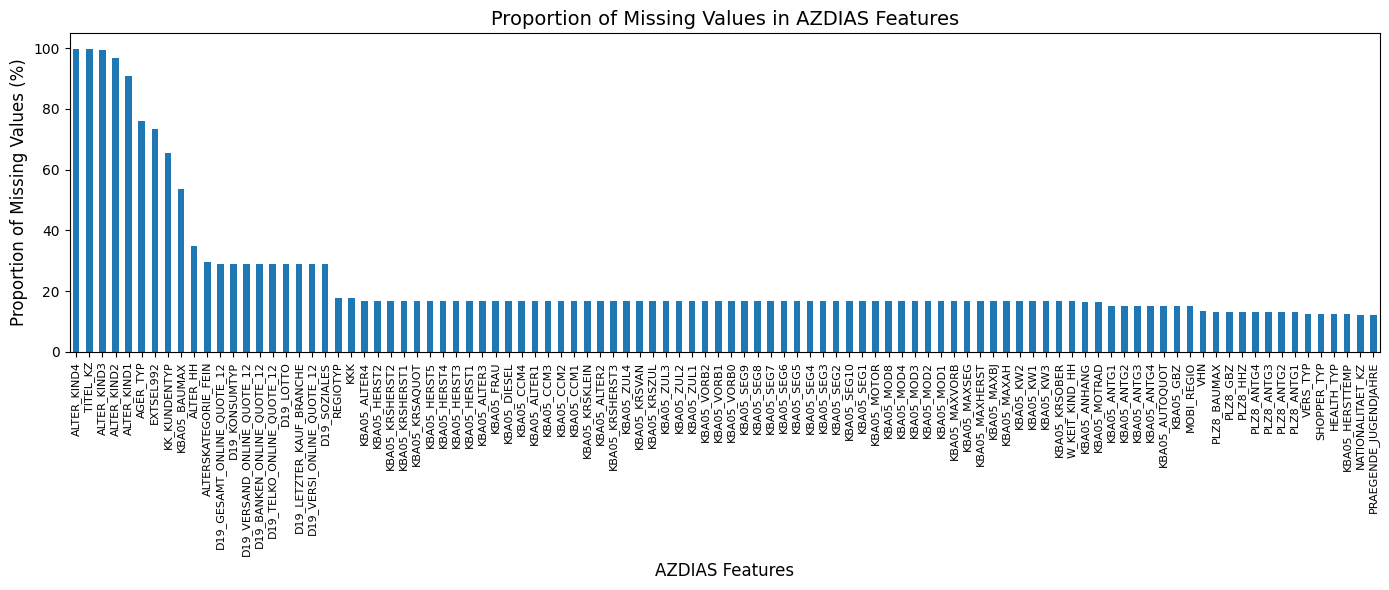

In [23]:
# missing value percentages for each column
missing_value_col_df = pd.DataFrame({
    'column_name': azdias.columns,
    'percent_missing': percent_missing_col
})

missing_value_col_df = missing_value_col_df.sort_values(by='percent_missing', ascending=False)

# Plot the proportion of missing values for the first 100 columns
plt.figure(figsize=(12, 6))
missing_value_col_df.head(100).plot(
    x='column_name', 
    y='percent_missing', 
    kind='bar', 
    legend=False, 
    figsize=(14, 6)
)

plt.xlabel('AZDIAS Features', fontsize=12)
plt.ylabel('Proportion of Missing Values (%)', fontsize=12)
plt.title('Proportion of Missing Values in AZDIAS Features', fontsize=14)
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

- There are many missing values in the dataset, 8 features have more than 40% missing values

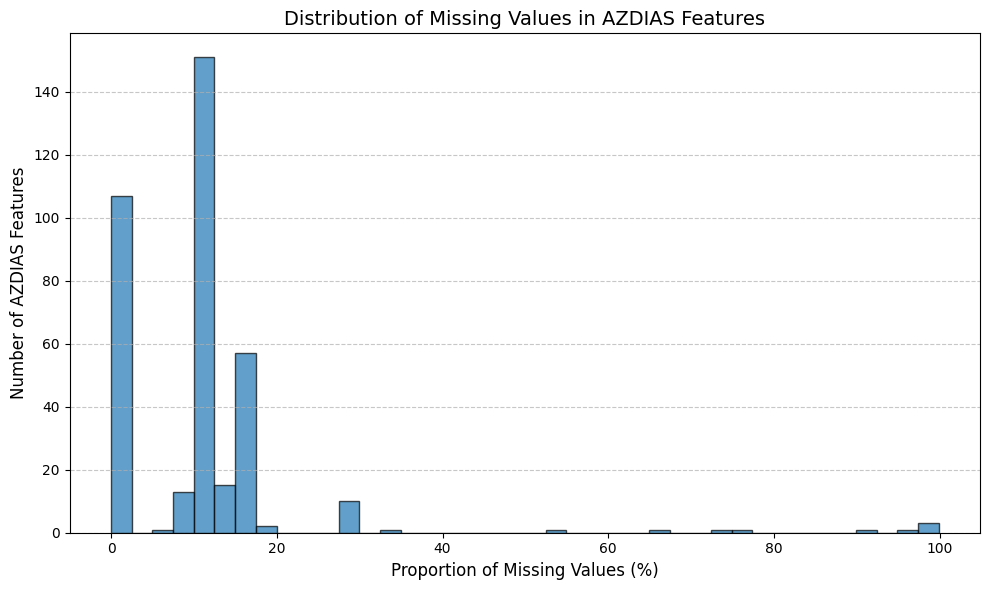

In [24]:
# Plot a histogram of the proportion of missing values
plt.figure(figsize=(10, 6))
plt.hist(percent_missing_col, bins=40, edgecolor='black', alpha=0.7)
plt.xlabel('Proportion of Missing Values (%)', fontsize=12)
plt.ylabel('Number of AZDIAS Features', fontsize=12)
plt.title('Distribution of Missing Values in AZDIAS Features', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- Most of the columns have percentage of missing values of less than 20%. Therefore, we can use 20% as the threshold


In [25]:
columns_to_drop = percent_missing_col[percent_missing_col > 20].index
columns_to_drop


Index(['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12',
       'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KBA05_BAUMAX',
       'KK_KUNDENTYP', 'TITEL_KZ'],
      dtype='object')

In [26]:
# drop columns
azdias.drop(labels=columns_to_drop, axis=1, inplace=True)
azdias.shape

(891221, 346)

In [27]:
# percent missing at row level
percent_missing_row = azdias.isnull().mean(axis=1) * 100


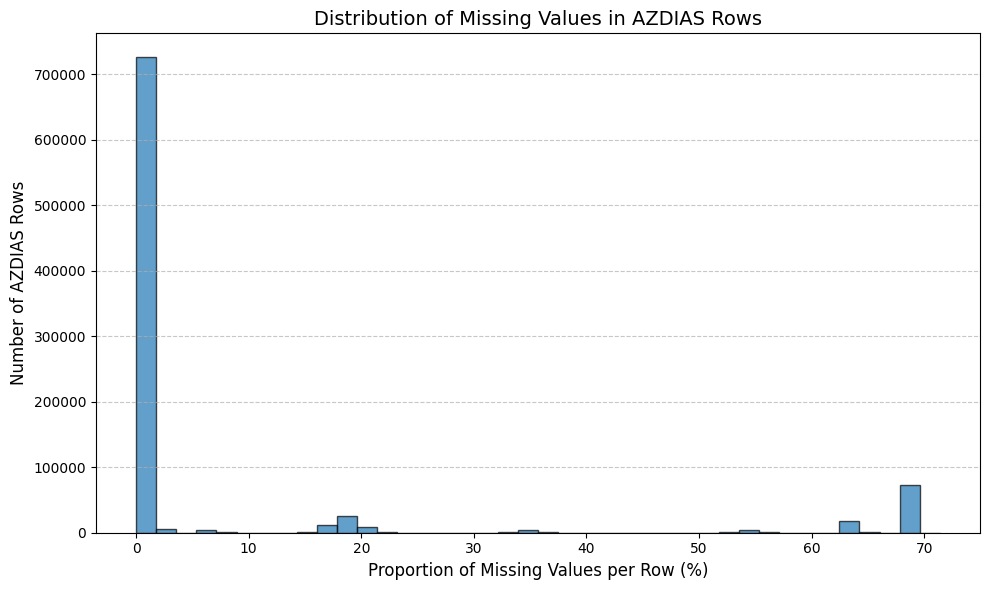

In [28]:
# Plot a histogram for the proportion of missing values in rows
plt.figure(figsize=(10, 6))
plt.hist(percent_missing_row, bins=40, edgecolor='black', alpha=0.7)
plt.xlabel('Proportion of Missing Values per Row (%)', fontsize=12)
plt.ylabel('Number of AZDIAS Rows', fontsize=12)
plt.title('Distribution of Missing Values in AZDIAS Rows', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- The majority of rows have less than 10% missing values. However, a significant number of rows contain more than 60% missing values. We decided to drop rows with more than 10% missing values.

In [29]:
# drop all the rows with over 10% missing values
azdias = azdias[percent_missing_row <= 10]

In [30]:
azdias.shape

(737287, 346)

#### Deal with categorical, mixed and binary features

In [31]:
azdias_categorical_cols = azdias.columns[azdias.dtypes == "object"]
for col in azdias_categorical_cols:
    print(col, ': ', len(azdias[col].unique()), 'values, ', azdias[col].unique())

CAMEO_DEU_2015 :  46 values,  ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '7A' '5D' '9E' '5C'
 '9B' '1B' '8B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6E' '6D' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C' 'XX']
CAMEO_DEUG_2015 :  20 values,  [8.0 4.0 2.0 6.0 1.0 9.0 7.0 5.0 3.0 nan '3' '7' '2' '4' '9' '6' '8' '5'
 '1' 'X']
CAMEO_INTL_2015 :  44 values,  [51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 41.0 34.0 55.0 33.0 25.0 nan
 23.0 31.0 52.0 45.0 35.0 44.0 32.0 '24' '41' '12' '51' '44' '35' '23'
 '25' '14' '34' '52' '55' '31' '32' '22' '15' '13' '43' '45' '33' '54'
 'XX']
EINGEFUEGT_AM :  2819 values,  ['1992-02-10 00:00:00' '1992-02-12 00:00:00' '1997-04-21 00:00:00' ...
 '1994-10-24 00:00:00' '2000-03-09 00:00:00' '2005-03-19 00:00:00']
OST_WEST_KZ :  2 values,  ['W' 'O']


In [32]:
# re-encode binary categorical variables
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].map({'W': 0, 'O': 1})

In [33]:
# treat 'X' and 'XX' as nan values and convert to float
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].replace('X', np.nan).astype(float)
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].replace('XX', np.nan).astype(float)


In [34]:
# Convert EINGEFUEGT_AM to year
azdias["EINGEFUEGT_AM"] = pd.to_datetime(azdias["EINGEFUEGT_AM"])
azdias["EINGEFUEGT_AM"] = azdias["EINGEFUEGT_AM"].dt.year

In [35]:
azdias['EINGEFUEGT_AM'].unique()

array([1992, 1997, 1995, 1996, 2005, 2004, 2000, 1994, 1993, 2003, 1999,
       2001, 1998, 2002, 1991], dtype=int32)

In [36]:
azdias = azdias.drop(columns='EINGEFUEGT_AM')

In [37]:
categorical_cols = [col for col in azdias.select_dtypes(include=['object']).columns]


In [38]:
# Drop Multi-Level Categorical Columns
multi_level_threshold = 5 
multi_level_categorical_cols = [col for col in categorical_cols if azdias[col].nunique() > multi_level_threshold]
azdias_clean = azdias.drop(columns=multi_level_categorical_cols)
print(f"Dropped multi-level categorical columns: {multi_level_categorical_cols}")

Dropped multi-level categorical columns: ['CAMEO_DEU_2015']


In [39]:
# numerical Columns
binary_cols = [col for col in azdias.columns if azdias[col].nunique(dropna=True) == 2]
categorical_cols = [col for col in azdias_clean.select_dtypes(include=['object']).columns]
numerical_cols = list(set(azdias_clean.columns) - set(binary_cols) - set(categorical_cols))


In [40]:
# create pipelines for different column types
binary_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# combine pipelines
transformers = [
    ('binary', binary_pipeline, binary_cols),
    ('categorical', categorical_pipeline, categorical_cols),
    ('numerical', numerical_pipeline, numerical_cols)
]
column_transformer = ColumnTransformer(transformers=transformers)

# transform the dataframe
azdias_trans = column_transformer.fit_transform(azdias)

# retrieve column names for one-hot encoded features
if categorical_cols:
    dummy_cols = list(column_transformer.named_transformers_['categorical'].named_steps['onehot'].get_feature_names_out(categorical_cols))
else:
    dummy_cols = []

# combine column names for transformed dataframe
column_names = binary_cols + dummy_cols + numerical_cols
azdias_trans = pd.DataFrame(azdias_trans, columns=column_names)


#### Data Cleaning function 

In [41]:
columns_to_drop_2 = [x for x in columns_to_drop if x in customers.columns]

In [42]:
def preprocess_dataframe(df,columns_to_drop, multi_level_threshold=5):
    """
    preprocess a dataframe with similar operations applied to azdias.

    parameters:
    df (pd.DataFrame): the dataframe to preprocess.
    multi_level_threshold (int): maximum number of unique values for categorical features to keep.

    returns:
    pd.DataFrame: transformed dataframe ready for modeling.
    """
    # drop specified columns
    df.drop(labels=columns_to_drop, axis=1, inplace=True)
    
    # filter rows based on missing value threshold
    percent_missing_row = df.isnull().mean(axis=1) * 100
    df = df[percent_missing_row <= 10]
    
    # re-encode binary categorical variables
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 0, 'O': 1})

    
    # replace 'x' and 'xx' as nan and convert to float
    if 'CAMEO_DEUG_2015' in df.columns:
        df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', np.nan).astype(float)
    if 'CAMEO_INTL_2015' in df.columns:
        df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace('XX', np.nan).astype(float)
    
    df.drop(columns='EINGEFUEGT_AM', inplace=True)
    
    # identify categorical columns
    categorical_cols = [col for col in df.select_dtypes(include=['object']).columns]
    
    # drop multi-level categorical columns
    multi_level_categorical_cols = [col for col in categorical_cols if df[col].nunique() > multi_level_threshold]
    df.drop(columns=multi_level_categorical_cols, inplace=True)
    print(f"dropped multi-level categorical columns: {multi_level_categorical_cols}")
    
    # identify column types
    binary_cols = [col for col in df.columns if df[col].nunique(dropna=True) == 2]
    categorical_cols = [col for col in df.select_dtypes(include=['object']).columns]
    numerical_cols = list(set(df.columns) - set(binary_cols) - set(categorical_cols))
    
    # create pipelines for different column types
    binary_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent'))
    ])
    
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    # combine pipelines
    transformers = [
        ('binary', binary_pipeline, binary_cols),
        ('categorical', categorical_pipeline, categorical_cols),
        ('numerical', numerical_pipeline, numerical_cols)
    ]
    column_transformer = ColumnTransformer(transformers=transformers)
    
    # transform the dataframe
    df_trans = column_transformer.fit_transform(df)
    
    # retrieve column names for one-hot encoded features
    if categorical_cols:
        dummy_cols = list(column_transformer.named_transformers_['categorical'].named_steps['onehot'].get_feature_names_out(categorical_cols))
    else:
        dummy_cols = []
    
    # combine column names for transformed dataframe
    column_names = binary_cols + dummy_cols + numerical_cols
    
    # return transformed dataframe
    return pd.DataFrame(df_trans, columns=column_names)


#### Cleaning CUSTOMERS dataset

In [43]:
customers.drop(['CUSTOMER_GROUP', 'PRODUCT_GROUP', 'ONLINE_PURCHASE'], axis=1, inplace=True)

In [44]:
customers_trans =  preprocess_dataframe(df= customers,columns_to_drop = columns_to_drop_2, multi_level_threshold=5)

/var/folders/h2/0dmxrjm55dv2p0qsyjp2qw1m0000gn/T/ipykernel_22293/43289395.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 0, 'O': 1})
/var/folders/h2/0dmxrjm55dv2p0qsyjp2qw1m0000gn/T/ipykernel_22293/43289395.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', np.nan).astype(float)
/var/folders/h2/0dmxrjm55dv2p0qsyjp2qw1m0000gn/T/ipykernel_22293/43289395.py:27: SettingWithCopyWarning: 
A value is 

dropped multi-level categorical columns: ['CAMEO_DEU_2015']


In [45]:
customers_trans.shape

(135144, 344)

In [46]:
azdias_trans.shape

(737287, 344)

In [47]:
list(set(customers_trans)-set(azdias_trans))


[]

#### Scale features



In [48]:
# use Standard Scaler to scale features
scaler = StandardScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_trans), columns=azdias_trans.columns)
customers_scaled = pd.DataFrame(scaler.fit_transform(customers_trans), columns=customers_trans.columns)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

There are 344 features in the transformed azdias dataset. Principal Component Analysis can be used to reduce the feature range.

### Reduce features

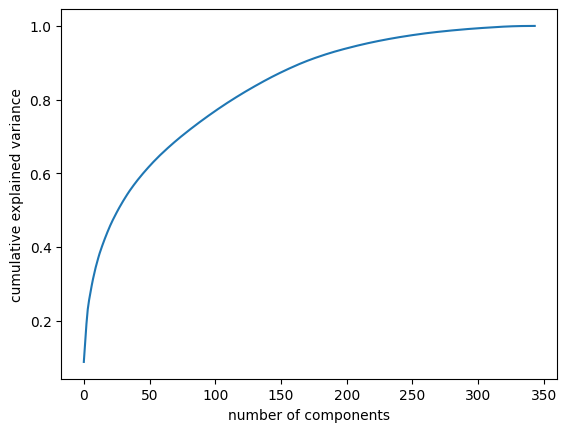

In [49]:
# Fit PCA object
pca = PCA().fit(azdias_trans)

# Plot scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [50]:

cum_variance = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_), columns=['cumulative_variance'])
cum_variance.set_index(cum_variance.index+1, inplace=True)

print('90% threshold of variance explained by {} components.'.format(cum_variance[cum_variance['cumulative_variance']>.90].index[0]))

90% threshold of variance explained by 168 components.


- In 344 features in the dataset, there are 168 that explain 90% of the variance. The dataset can be reduced by more than half of its features while only losing 10% of variance.

In [51]:
# Reduce the azdias dataset
pca = PCA(n_components=168).fit(azdias_trans)
azdias_reduced = pca.transform(azdias_trans)
azdias_reduced = pd.DataFrame(azdias_reduced)
print(pca.explained_variance_ratio_.sum())

0.8998565639871055


In [52]:
azdias_reduced.shape

(737287, 168)

### Clustering

In [53]:
scores = []
for i in range(1, 31):
    km = KMeans(n_clusters=i, init='k-means++')
    km.fit(azdias_reduced.sample(20000))
    scores.append(km.inertia_)

Text(0, 0.5, 'Average Within-Cluster Distances')

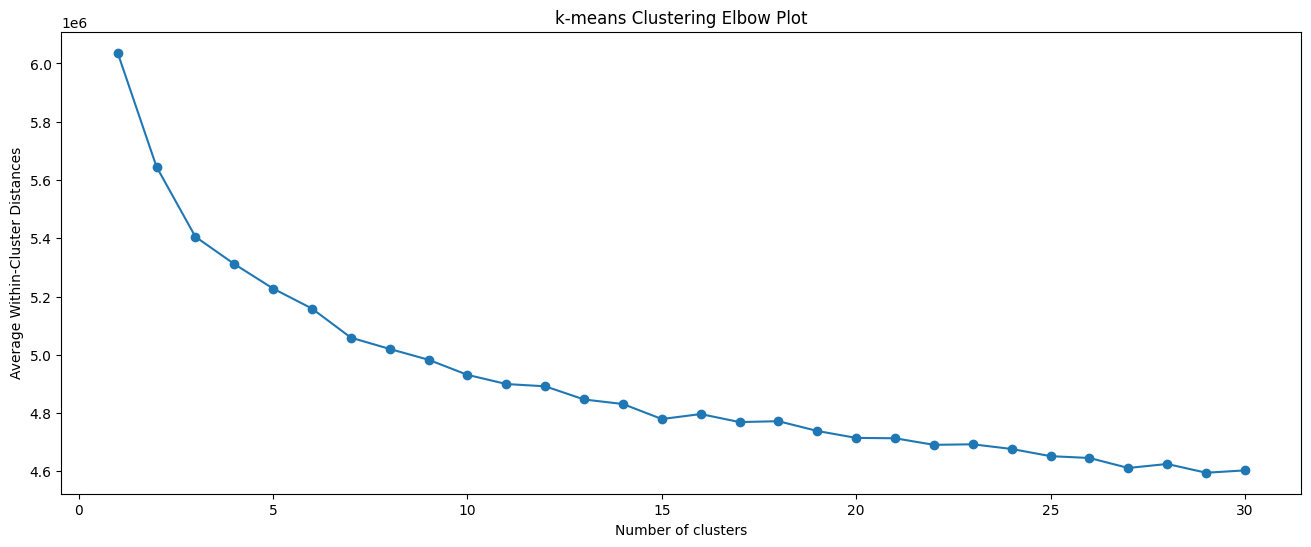

In [54]:
# draw elbow plot
centers = np.linspace(1,30,30)
plt.figure(figsize=(16, 6))
plt.plot(centers, scores, '-o')
plt.title('k-means Clustering Elbow Plot')
plt.xlabel("Number of clusters")
plt.ylabel("Average Within-Cluster Distances")

- There drop in average distance at 13 clusters is pretty clear, so 13 clusters will be used.

In [55]:
# create cluster pipeline
cluster_pipeline = Pipeline([
    ('reduce', PCA(n_components = 168)),
    ('cluster', KMeans(n_clusters = 13, init = 'k-means++'))
])

In [56]:
azdias_scaled.shape

(737287, 344)

In [57]:
customers_scaled.shape

(135144, 344)

In [58]:
def order_columns_with_fill(df_to_order, reference_df):
    """
    reorder the columns of a dataframe to match another, filling missing columns with NaN.

    parameters:
    df_to_order (pd.DataFrame): the dataframe to reorder.
    reference_df (pd.DataFrame): the dataframe with the desired column order.

    returns:
    pd.DataFrame: a dataframe with columns reordered and missing columns filled with NaN.
    """
    # get the reference column order
    reference_order = reference_df.columns.tolist()

    # add missing columns to the dataframe to reorder
    for col in reference_order:
        if col not in df_to_order.columns:
            df_to_order[col] = np.nan

    # reorder columns to match the reference
    reordered_df = df_to_order[reference_order]

    return reordered_df

# usage example
customers_scaled = order_columns_with_fill(customers_scaled, azdias_scaled)


In [59]:

# fit cluster pipeline and create clustered general population dataframe
cluster_pipeline.fit(azdias_scaled)
azdias_clustered = pd.DataFrame(cluster_pipeline.predict(azdias_scaled), columns = ['Cluster'])


In [60]:
customers_clustered = pd.DataFrame(cluster_pipeline.predict(customers_scaled), columns = ['Cluster'])

In [61]:
# Save clustered datasets to pickle files
azdias_clustered.to_pickle('azdias_clustered')
customers_clustered.to_pickle('customers_clustered')

In [62]:
# calculate the cluster counts for the population and customers
population_clusters = azdias_clustered['Cluster'].value_counts().sort_index()
customer_clusters = customers_clustered['Cluster'].value_counts().sort_index()

# combine the cluster counts into a single dataframe
clusters = pd.concat([population_clusters, customer_clusters], axis=1).reset_index()

# rename columns 
clusters.columns = ['cluster', 'population', 'customers']

# calculate the difference in percentage representation between customers and population
clusters['difference'] = (
    (clusters['customers'] / clusters['customers'].sum() * 100) -
    (clusters['population'] / clusters['population'].sum() * 100)
)

# display the resulting dataframe
clusters


,cluster,population,customers,difference
0,0,79878,19912,3.899869
1,1,32467,3008,-2.177803
2,2,61222,12461,0.916849
3,3,63918,17000,3.909824
4,4,51565,9067,-0.284744
5,5,32081,2015,-2.860221
6,6,67891,19151,4.962592
7,7,56308,8336,-1.468953
8,8,42208,4579,-2.336534
9,9,62240,12174,0.566409


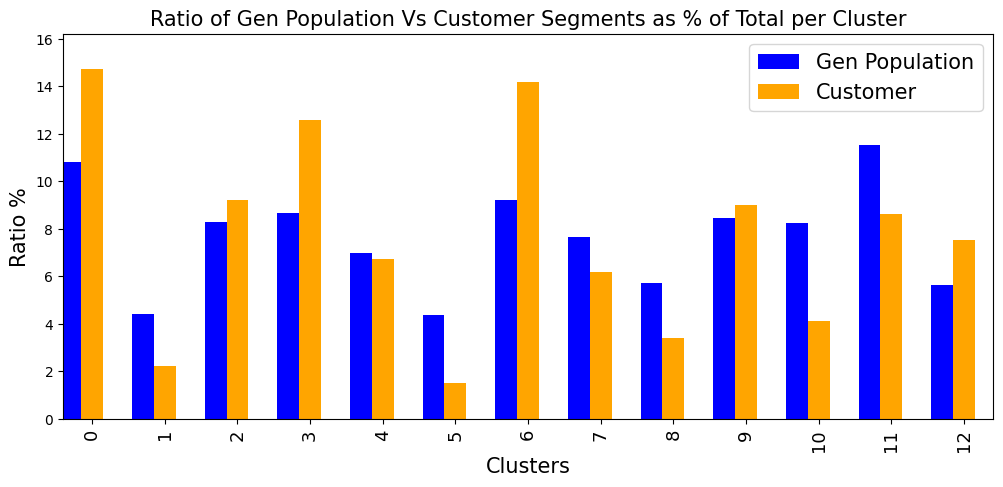

In [63]:
# calculate the percentage of each cluster
clusters['population_percent'] = ((clusters['population'] / clusters['population'].sum()) * 100).round(2)
clusters['customers_percent'] = ((clusters['customers'] / clusters['customers'].sum()) * 100).round(2)

# Plot the clusters
fig, ax = plt.subplots(figsize=(12, 5))

clusters['population_percent'].plot(kind='bar', color='blue', width=-0.3, align='edge', position=0, label='Gen Population', ax=ax)

clusters['customers_percent'].plot(kind='bar', color='orange', width=0.3, align='edge', position=1, label='Customer', ax=ax)

ax.set_xlabel('Clusters', fontsize=15)
ax.set_ylabel('Ratio %', fontsize=15)
ax.set_xticks(range(len(clusters)))
ax.set_xticklabels(range(len(clusters)), fontsize=13)
ax.tick_params(axis='x', labelsize=13)
ax.margins(x=0.05, y=0.1)

ax.legend(fontsize=15)
ax.set_title('Ratio of Gen Population Vs Customer Segments as % of Total per Cluster', fontsize=15)

plt.show()


- From the chart and the table above, we observe that certain clusters (1,2,5,7) are overrepresented by customers, while others are underrepresented (0,3,4,10). This insight can help us refine our strategy for targeting future customers more effectively.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### Load and clean data

In [64]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train.head(2)

/var/folders/h2/0dmxrjm55dv2p0qsyjp2qw1m0000gn/T/ipykernel_22293/216366203.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3


In [65]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test.head(2)


/var/folders/h2/0dmxrjm55dv2p0qsyjp2qw1m0000gn/T/ipykernel_22293/1902083410.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4


In [66]:
mailout_train.shape

(42962, 367)

In [67]:
# clean dataset
mailout_train =  preprocess_dataframe(df= mailout_train,columns_to_drop = columns_to_drop_2, multi_level_threshold=5)
mailout_test =  preprocess_dataframe(df= mailout_test,columns_to_drop = columns_to_drop_2, multi_level_threshold=5)

/var/folders/h2/0dmxrjm55dv2p0qsyjp2qw1m0000gn/T/ipykernel_22293/43289395.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 0, 'O': 1})
/var/folders/h2/0dmxrjm55dv2p0qsyjp2qw1m0000gn/T/ipykernel_22293/43289395.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', np.nan).astype(float)
/var/folders/h2/0dmxrjm55dv2p0qsyjp2qw1m0000gn/T/ipykernel_22293/43289395.py:27: SettingWithCopyWarning: 
A value is 

dropped multi-level categorical columns: ['CAMEO_DEU_2015']


/var/folders/h2/0dmxrjm55dv2p0qsyjp2qw1m0000gn/T/ipykernel_22293/43289395.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 0, 'O': 1})
/var/folders/h2/0dmxrjm55dv2p0qsyjp2qw1m0000gn/T/ipykernel_22293/43289395.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', np.nan).astype(float)
/var/folders/h2/0dmxrjm55dv2p0qsyjp2qw1m0000gn/T/ipykernel_22293/43289395.py:27: SettingWithCopyWarning: 
A value is 

dropped multi-level categorical columns: ['CAMEO_DEU_2015']


In [68]:
mailout_train.shape

(34214, 345)

In [69]:
mailout_test.shape

(34177, 344)

In [70]:
mailout_train['RESPONSE'].value_counts()

RESPONSE
0.0    33790
1.0      424
Name: count, dtype: int64

### ML model

- This is a binary classification problem.
- Here I will use **Logistic Regression**, **Random Forest**, and **Gradient Boosting**, then choose the best model.


In [ ]:
def draw_learning_curves(X, y, estimator, num_trainings=10):
    """
    Draw learning curves showing the training and validation AUC scores
    for an estimator with varying training sample sizes.
    """
    # Generate learning curve data
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring='roc_auc', train_sizes=np.linspace(0.1, 1.0, num_trainings), cv=5
    )

    # Calculate mean and standard deviation for training and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    # Print the final AUC scores for training and validation
    print(f"Final AUC Train Score: {train_scores_mean[-1]:.2f}")
    print(f"Final AUC Validation Score: {test_scores_mean[-1]:.2f}")

    # Plot the learning curves
    plt.figure(figsize=(8, 6))
    plt.plot(
        train_sizes * 100 / len(X), train_scores_mean, 'o-', color="green", label="Training AUC Score"
    )
    plt.plot(
        train_sizes * 100 / len(X), test_scores_mean, 'o-', color="orange", label="Validation AUC Score"
    )

    # Customize the plot
    plt.title("Learning Curves", fontsize=16)
    plt.xlabel("Percentage of Training Set", fontsize=12)
    plt.ylabel("AUC Score", fontsize=12)
    plt.ylim(0.45, 1.05)
    plt.grid(True)
    plt.xticks(np.arange(0, 110, 10))
    plt.yticks(np.arange(0.45, 1.05, 0.05))
    plt.legend(loc="best")
    plt.tight_layout()

    plt.show()

In [80]:
# encoding categorical variables
categorical_cols = mailout_train.select_dtypes(include='object').columns
for col in categorical_cols:
    le = LabelEncoder()
    mailout_train[col] = le.fit_transform(mailout_train[col].astype(str))

# feature and target separation
X = mailout_train.drop(['RESPONSE'], axis=1)
y = mailout_train['RESPONSE']


In [81]:
# compute class weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)

# convert to dictionary 
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

class_weights_dict

{0: 0.5062740455756141, 1: 40.346698113207545}

In [88]:

# splitting the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_scaled = scaler.fit_transform(X)



In [89]:
# Model training and evaluation
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced',max_iter=1000),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier()
}



Drawing learning curves for Logistic Regression...
Final AUC Train Score: 0.85
Final AUC Validation Score: 0.64


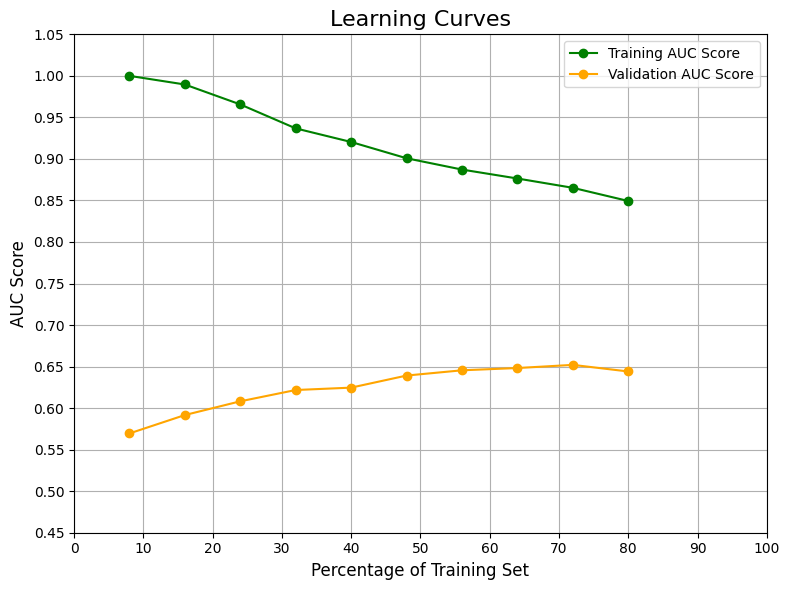

Drawing learning curves for Random Forest...
Final AUC Train Score: 1.00
Final AUC Validation Score: 0.62


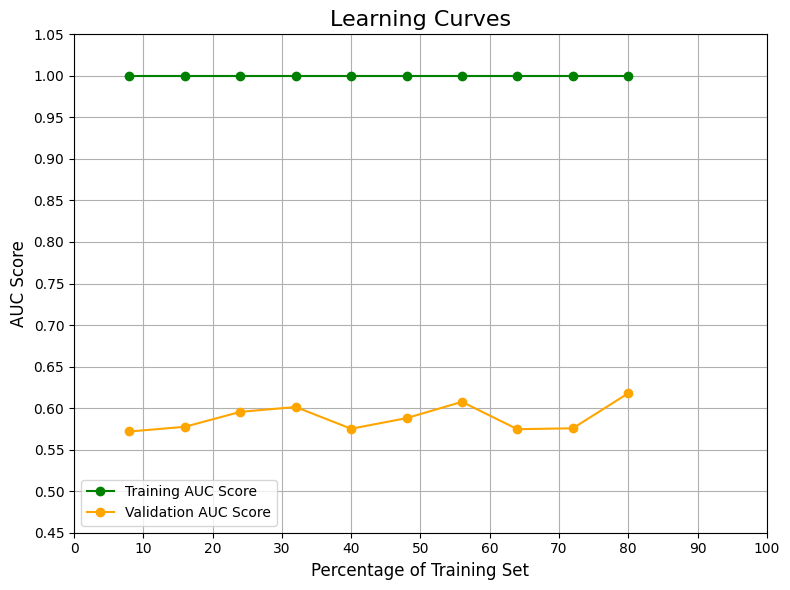

Drawing learning curves for Gradient Boosting...
Final AUC Train Score: 0.94
Final AUC Validation Score: 0.70


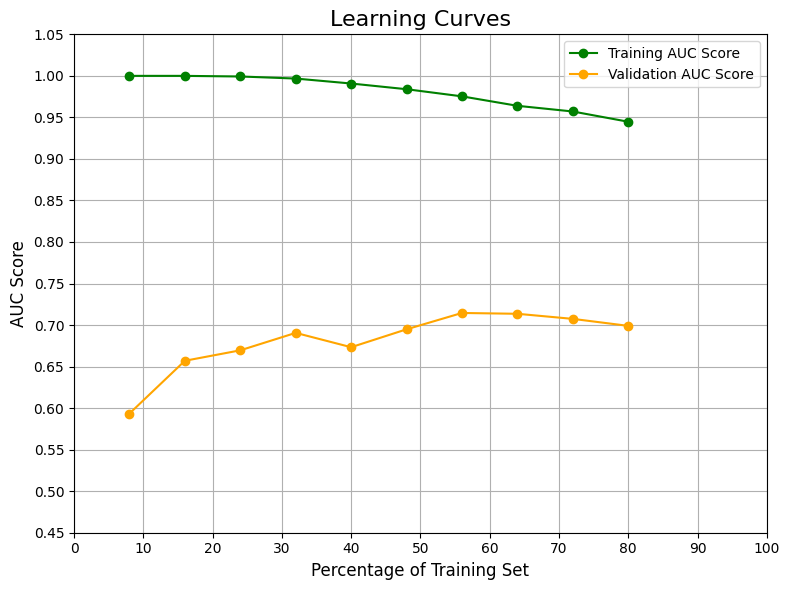

In [90]:
# Draw learning curves for each model
for model_name, model in models.items():
    print(f"Drawing learning curves for {model_name}...")
    draw_learning_curves(X_scaled, y, model, num_trainings=10)

- **Random Forest** had the lowest validation score and a consistently high training score, indicating high bias and poor generalization.
- **Logistic Regression** and **Gradient Boosting** showed improved validation scores as sample size increased, reducing bias.

**Gradient Boosting** achieved the highest validation score, demonstrating the best balance between bias and variance. Thus, Gradient Boosting is selected as the optimal model for forecasting customer conversion.

### Tuning best parameters into the GradientBoosting 

In [91]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6]
}

gdb = GradientBoostingClassifier()
grid_search = GridSearchCV(gdb, param_grid, scoring='roc_auc', cv=5, verbose=1)
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_
print("\nBest Hyperparameters for Gradient Boosting:")
print(grid_search.best_params_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best Hyperparameters for Gradient Boosting:
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


In [93]:
y_val_proba_tuned = best_model.predict_proba(X_val_scaled)[:, 1]
auc_score_tuned = roc_auc_score(y_val, y_val_proba_tuned)
print(f"Validation AUC with Tuned Gradient Boosting: {auc_score_tuned:.3f}")

Validation AUC with Tuned Gradient Boosting: 0.710


In [94]:

# Extract the feature importances from the best model
feature_importances = best_model.feature_importances_

feature_names = X.columns


feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance
feature_df = feature_df.sort_values(by='Importance', ascending=False)

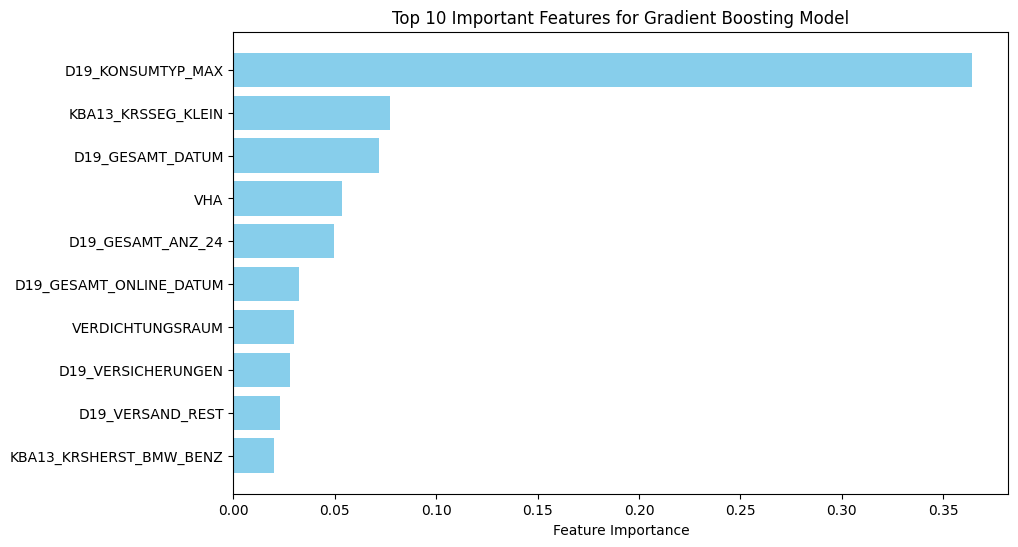

In [97]:
top_features = feature_df.head(10)
# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features for Gradient Boosting Model')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

### Prediction on test dataset

In [102]:
X_test = mailout_test.copy()

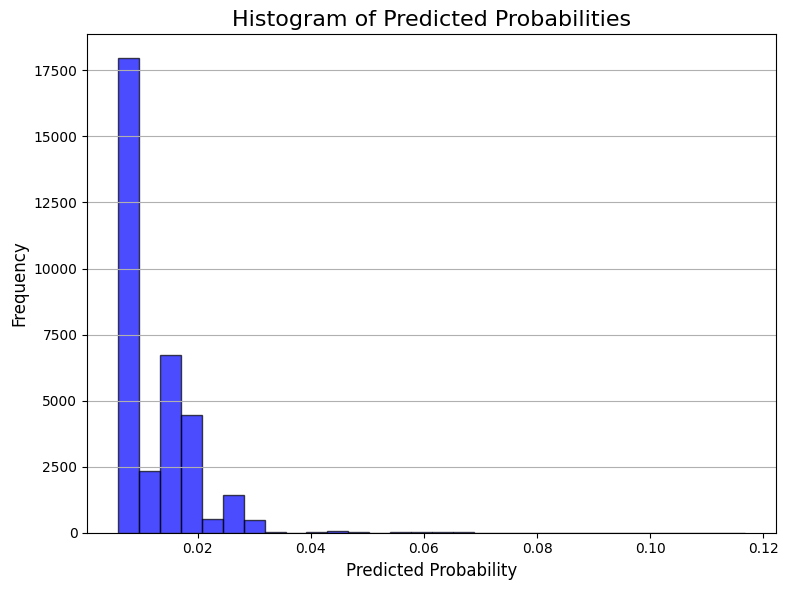

In [105]:
# encoding categorical variables
categorical_cols_test = X_test.select_dtypes(include='object').columns
for col in categorical_cols_test:
    le = LabelEncoder()
    X_test[col] = le.fit_transform(X_test[col].astype(str))

# Scale the test set using the scaler from training
X_test_scaled = scaler.transform(X_test)

# Make predictions using the tuned model
predicted_probabilities = best_model.predict_proba(X_test_scaled)[:, 1]

# Histogram of predicted probabilities
plt.figure(figsize=(8, 6))
plt.hist(predicted_probabilities, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title("Histogram of Predicted Probabilities", fontsize=16)
plt.xlabel("Predicted Probability", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
predicted_values =  best_model.predict(X_test_scaled)
unique_elements, counts = np.unique(predicted_values, return_counts=True)

count_dict = dict(zip(unique_elements, counts))

print(count_dict)

{0.0: 34177}


The result, where all predicted probabilities are ≤ 0.12 and the model predicts false (0) for all responses, suggests that the model is highly biased toward the negative class (non-conversion).